In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import os
import cv2


In [16]:
def rgb_to_hsv(img):

    # chuyển về khoảng 0-255
    img_255 = (img * 255).astype(np.uint8)
    
    # rgb->hsv
    img_hsv = cv2.cvtColor(img_255, cv2.COLOR_RGB2HSV)
    

    img_hsv = img_hsv.astype(np.float32)
    img_hsv[:, :, 0] = img_hsv[:, :, 0] / 179.0  # H
    img_hsv[:, :, 1] = img_hsv[:, :, 1] / 255.0  # S
    img_hsv[:, :, 2] = img_hsv[:, :, 2] / 255.0  # V
    
    return img_hsv
class ImageDataGeneratorHSV(ImageDataGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def standardize(self, x):
        x = super().standardize(x)  # rescale
        x = rgb_to_hsv(x)  # -->hsv
        return x

In [15]:
# Đường dẫn dataset
train_dir = "../dataset_splits/train"
validation_dir = "../dataset_splits/validation"
test_dir = "../dataset_splits/test"

# Hyperparameters
image_size = 150
batch_size = 32
epochs = 10       #đổi số epoch để chạy nhiều hơn dùm nha
learning_rate = 1e-3
num_classes = 6
color_mode="hsv"
channels = 3  

In [18]:

train_datagen = ImageDataGeneratorHSV(rescale=1./255)
validation_datagen = ImageDataGeneratorHSV(rescale=1./255)
test_datagen = ImageDataGeneratorHSV(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Lưu class names
class_names = list(train_generator.class_indices.keys())

steps_per_epoch = int(np.ceil(train_generator.samples / batch_size))
validation_steps = int(np.ceil(validation_generator.samples / batch_size))
test_steps = int(np.ceil(test_generator.samples / batch_size))

print(f"Classes: {list(train_generator.class_indices.keys())}")
print(f"  Mẫu Training:   {train_generator.samples:>5} → {steps_per_epoch:>3} steps")
print(f"  Mẫu Validation: {validation_generator.samples:>5} → {validation_steps:>3} steps")
print(f"  Mẫu Test:       {test_generator.samples:>5} → {test_steps:>3} steps")
print(f"  Input shape:    ({image_size}, {image_size}, {channels}) - HSV")

Found 7245 images belonging to 6 classes.
Found 1355 images belonging to 6 classes.
Found 448 images belonging to 6 classes.
Classes: ['0', '1', '2', '3', '4', '5']
  Mẫu Training:    7245 → 227 steps
  Mẫu Validation:  1355 →  43 steps
  Mẫu Test:         448 →  14 steps
  Input shape:    (150, 150, 3) - HSV


In [19]:
#Xây dựng model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(image_size, image_size, 3), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Fully Connected Layers
    layers.Flatten(name='flatten'),
    layers.Dropout(0.6, name='dropout'),
    layers.Dense(256, activation='relu', 
                kernel_regularizer=regularizers.l2(0.002), name='fc1'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Hiển thị kiến trúc model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601,478 (13.74 MB)

 Trainable params: 3,601,478 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [22]:
callbacks = [
    ModelCheckpoint(
        './saved_model/tomato_hsv_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Lưu model cuối cùng
model.save('./saved_model/tomato_hsv_final.h5')

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.5403 - auc: 0.8369 - loss: 1.5418 - precision: 0.6886 - recall: 0.3738
Epoch 1: val_accuracy improved from None to 0.78376, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 1: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6654 - auc: 0.9182 - loss: 1.1290 - precision: 0.7846 - recall: 0.5540 - val_accuracy: 0.7838 - val_auc: 0.9680 - val_loss: 0.7506 - val_precision: 0.8272 - val_recall: 0.7491 - learning_rate: 0.0010
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8144 - auc: 0.9694 - loss: 0.7348 - precision: 0.8539 - recall: 0.7687
Epoch 2: val_accuracy improved from 0.78376 to 0.85830, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 2: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 178s 784ms/step - accuracy: 0.8275 - auc: 0.9751 - loss: 0.6875 - precision: 0.8616 - recall: 0.7912 - val_accuracy: 0.8583 - val_auc: 0.9838 - val_loss: 0.6043 - val_precision: 0.8892 - val_recall: 0.8236 - learning_rate: 0.0010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8667 - auc: 0.9869 - loss: 0.5553 - precision: 0.8866 - recall: 0.8451
Epoch 3: val_accuracy improved from 0.85830 to 0.86273, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 3: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 158s 695ms/step - accuracy: 0.8715 - auc: 0.9873 - loss: 0.5448 - precision: 0.8909 - recall: 0.8497 - val_accuracy: 0.8627 - val_auc: 0.9837 - val_loss: 0.5968 - val_precision: 0.8818 - val_recall: 0.8421 - learning_rate: 0.0010
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8948 - auc: 0.9906 - loss: 0.4889 - precision: 0.9112 - recall: 0.8840
Epoch 4: val_accuracy improved from 0.86273 to 0.89963, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 4: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 223s 986ms/step - accuracy: 0.9005 - auc: 0.9909 - loss: 0.4822 - precision: 0.9150 - recall: 0.8871 - val_accuracy: 0.8996 - val_auc: 0.9900 - val_loss: 0.4945 - val_precision: 0.9158 - val_recall: 0.8827 - learning_rate: 0.0010
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9094 - auc: 0.9923 - loss: 0.4636 - precision: 0.9224 - recall: 0.8973
Epoch 5: val_accuracy improved from 0.89963 to 0.91808, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 5: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.9141 - auc: 0.9931 - loss: 0.4498 - precision: 0.9249 - recall: 0.9028 - val_accuracy: 0.9181 - val_auc: 0.9941 - val_loss: 0.4183 - val_precision: 0.9272 - val_recall: 0.9122 - learning_rate: 0.0010
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9331 - auc: 0.9958 - loss: 0.3831 - precision: 0.9416 - recall: 0.9244
Epoch 6: val_accuracy improved from 0.91808 to 0.93284, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 6: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9335 - auc: 0.9955 - loss: 0.3896 - precision: 0.9414 - recall: 0.9246 - val_accuracy: 0.9328 - val_auc: 0.9946 - val_loss: 0.3992 - val_precision: 0.9460 - val_recall: 0.9173 - learning_rate: 0.0010
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - auc: 0.9961 - loss: 0.3610 - precision: 0.9485 - recall: 0.9394
Epoch 7: val_accuracy did not improve from 0.93284
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.9375 - auc: 0.9956 - loss: 0.3779 - precision: 0.9442 - recall: 0.9322 - val_accuracy: 0.9299 - val_auc: 0.9943 - val_loss: 0.4043 - val_precision: 0.9365 - val_recall: 0.9255 - learning_rate: 0.0010
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9411 - auc: 0.9965 - loss: 0.3750 - precision: 0.9472 - recall: 0.9363
Epoch 8: val_accuracy did not improve from 0.93284
227/227 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - ac


Epoch 9: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9426 - auc: 0.9965 - loss: 0.3667 - precision: 0.9477 - recall: 0.9376 - val_accuracy: 0.9424 - val_auc: 0.9952 - val_loss: 0.3880 - val_precision: 0.9472 - val_recall: 0.9402 - learning_rate: 0.0010
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9510 - auc: 0.9973 - loss: 0.3381 - precision: 0.9556 - recall: 0.9462
Epoch 10: val_accuracy improved from 0.94244 to 0.94908, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 10: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.9538 - auc: 0.9972 - loss: 0.3339 - precision: 0.9581 - recall: 0.9504 - val_accuracy: 0.9491 - val_auc: 0.9952 - val_loss: 0.3532 - val_precision: 0.9540 - val_recall: 0.9491 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.


In [24]:
print("Đánh giá trên tập testing")
print("=" * 70)

# Evaluate model với số steps chính xác
test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

# Lấy predictions trên toàn bộ tập test
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# LẤY ĐÚNG SỐ LƯỢNG TRUE LABELS
y_true = test_generator.classes[:test_generator.samples]

# KIỂM TRA
print(f" Tổng mẫu test:    {test_generator.samples}")
print(f" Dự đoán được tạo: {len(y_pred)}")
print(f" Nhãn đúng được thu thập: {len(y_true)}")

# Đảm bảo cắt đúng số lượng
y_pred = y_pred[:test_generator.samples]
y_true = y_true[:test_generator.samples]

# Tính các metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 70)
print("Metric trên tập test")
print("=" * 70)
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"Test F1-Score:  {test_f1*100:.2f}%")
print(f"Test AUC:       {test_results[4]:.4f}")

Đánh giá trên tập testing


14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9554 - auc: 0.9968 - loss: 0.3401 - precision: 0.9618 - recall: 0.9554
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step
 Tổng mẫu test:    448
 Dự đoán được tạo: 448
 Nhãn đúng được thu thập: 448

Metric trên tập test
Test Loss:      0.3401
Test Accuracy:  95.54%
Test Precision: 95.69%
Test Recall:    95.54%
Test F1-Score:  95.43%
Test AUC:       0.9968


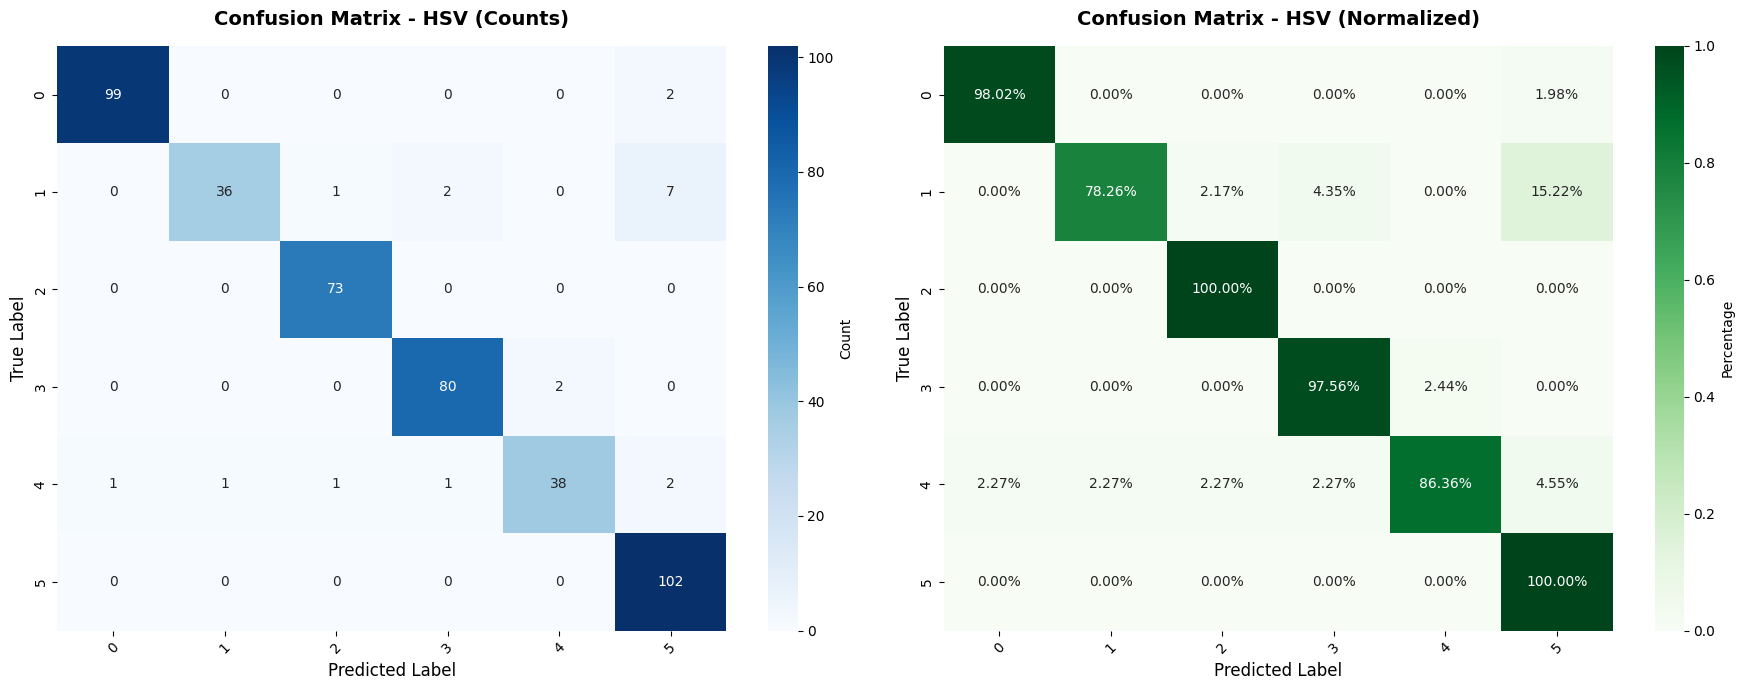


Classification Report (HSV)
              precision    recall  f1-score   support

           0     0.9900    0.9802    0.9851       101
           1     0.9730    0.7826    0.8675        46
           2     0.9733    1.0000    0.9865        73
           3     0.9639    0.9756    0.9697        82
           4     0.9500    0.8636    0.9048        44
           5     0.9027    1.0000    0.9488       102

    accuracy                         0.9554       448
   macro avg     0.9588    0.9337    0.9437       448
weighted avg     0.9569    0.9554    0.9543       448


Bảng metrics theo từng lớp:
              precision    recall  f1-score     support
0              0.990000  0.980198  0.985075  101.000000
1              0.972973  0.782609  0.867470   46.000000
2              0.973333  1.000000  0.986486   73.000000
3              0.963855  0.975610  0.969697   82.000000
4              0.950000  0.863636  0.904762   44.000000
5              0.902655  1.000000  0.948837  102.000000
accurac

In [25]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Confusion Matrix (Count)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax1)
    ax1.set_title('Confusion Matrix - HSV (Counts)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Confusion Matrix (Normalized)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'},
                ax=ax2)
    ax2.set_title('Confusion Matrix - HSV (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, class_names)

print("\nClassification Report (HSV)")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nBảng metrics theo từng lớp:")
print(df_report.to_string())

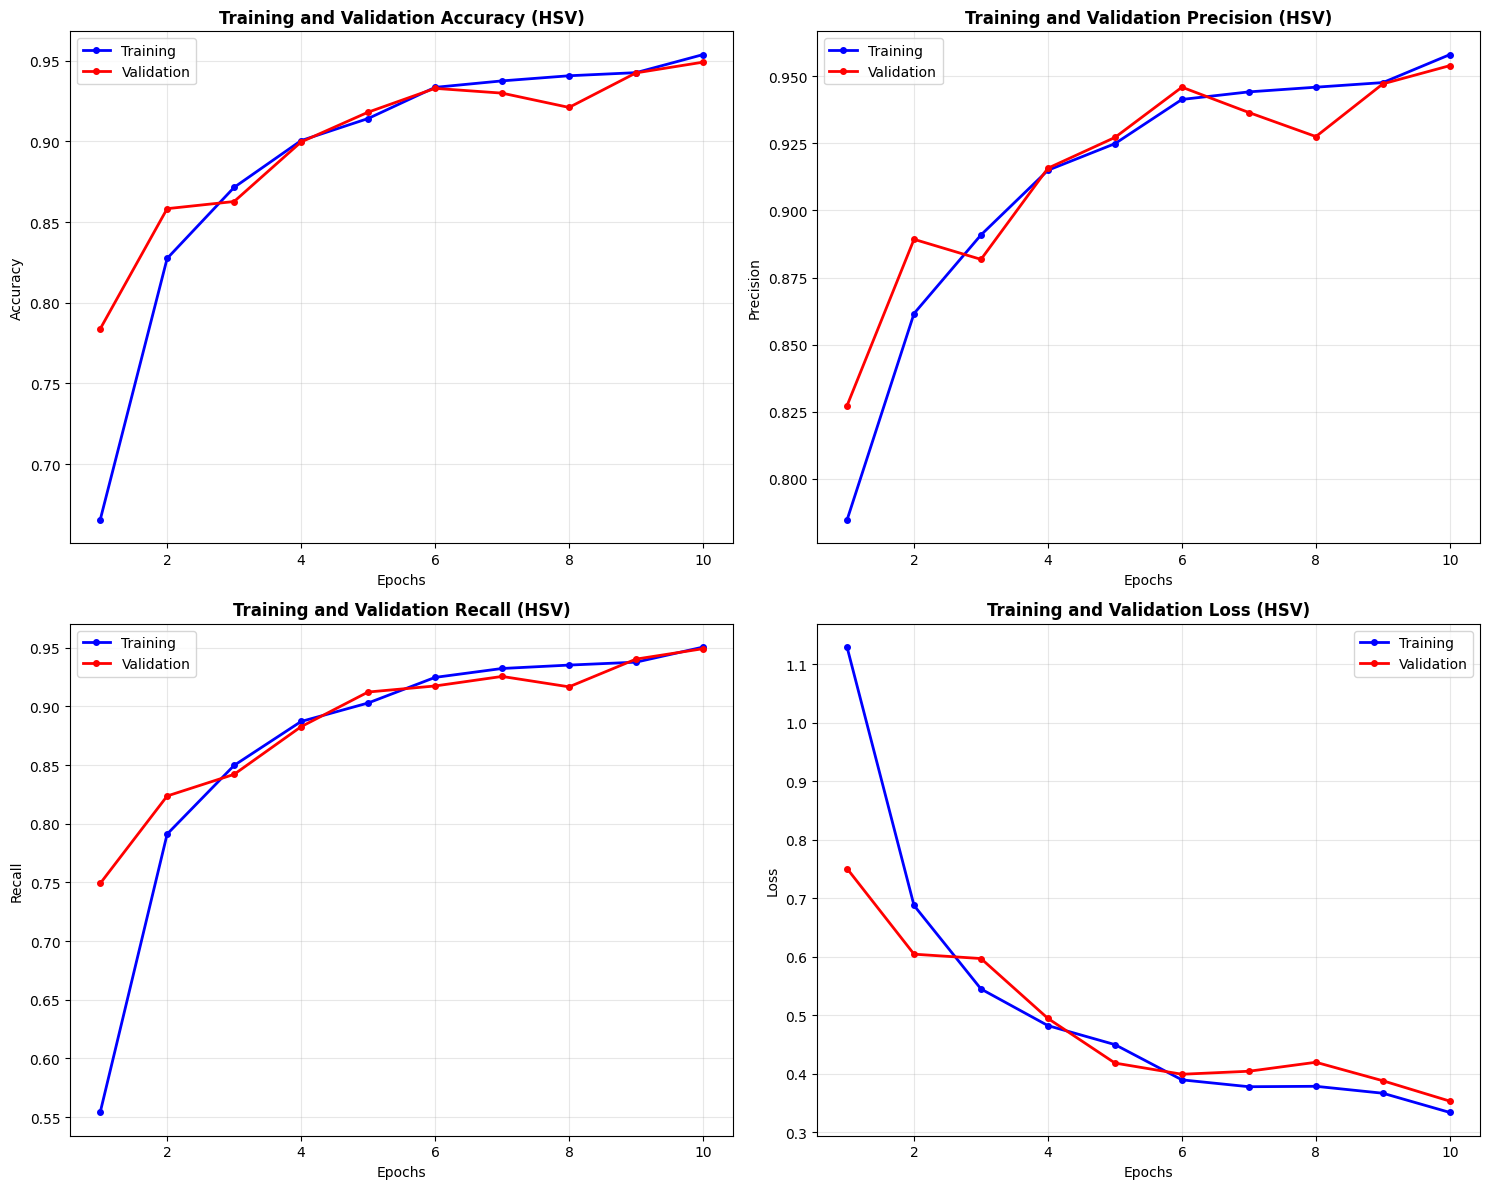


Kết quả training chi tiết (HSV)
Best Training Accuracy:    95.38%
Best Validation Accuracy:  94.91%
Best Training Precision:   95.81%
Best Validation Precision: 95.40%
Best Training Recall:      95.04%
Best Validation Recall:    94.91%
Final Training Loss:       0.3339
Final Validation Loss:     0.3532


In [26]:
def plot_training_history(history):
    """Vẽ biểu đồ quá trình training"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        if metric == 'loss':
            train_metric = history.history['loss']
            val_metric = history.history['val_loss']
            title = 'Training and Validation Loss (HSV)'
            ylabel = 'Loss'
        else:
            train_metric = history.history[metric]
            val_metric = history.history[f'val_{metric}']
            title = f'Training and Validation {metric.capitalize()} (HSV)'
            ylabel = metric.capitalize()
        
        ax.plot(epochs_range, train_metric, 'bo-', label=f'Training', linewidth=2, markersize=4)
        ax.plot(epochs_range, val_metric, 'ro-', label=f'Validation', linewidth=2, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("Kết quả training chi tiết (HSV)")
    print("=" * 70)
    print(f"Best Training Accuracy:    {max(history.history['accuracy'])*100:.2f}%")
    print(f"Best Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Best Training Precision:   {max(history.history['precision'])*100:.2f}%")
    print(f"Best Validation Precision: {max(history.history['val_precision'])*100:.2f}%")
    print(f"Best Training Recall:      {max(history.history['recall'])*100:.2f}%")
    print(f"Best Validation Recall:    {max(history.history['val_recall'])*100:.2f}%")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")

plot_training_history(history)

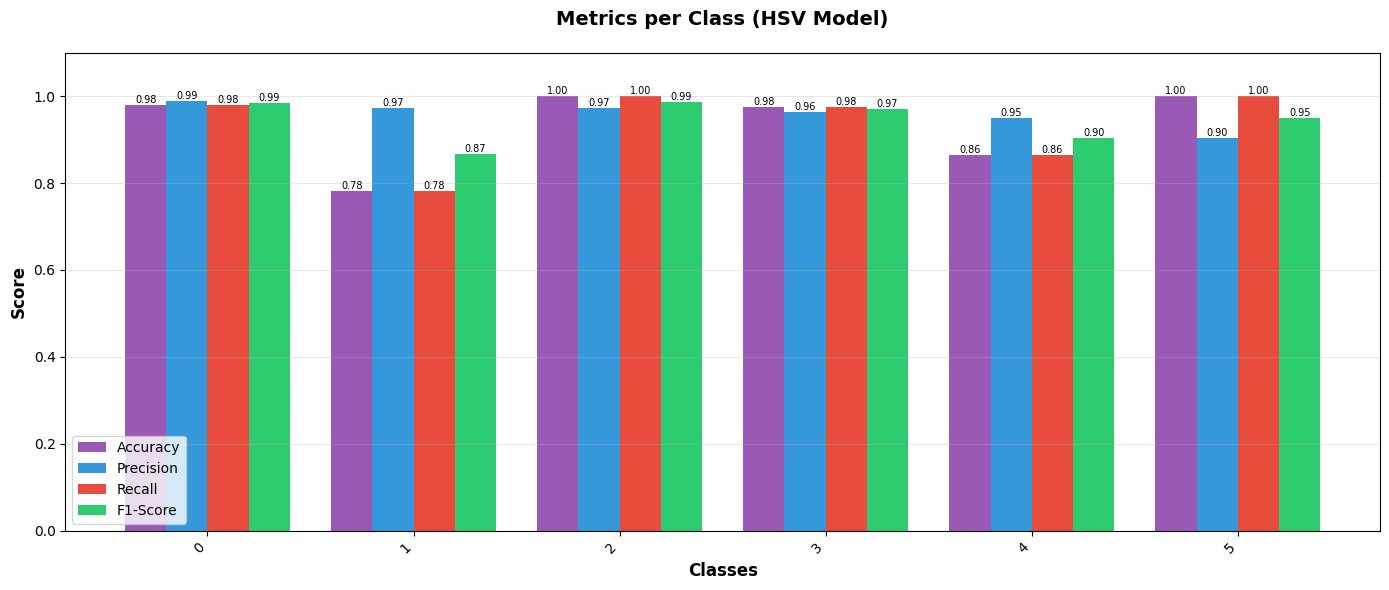


Metrics cho từng lớp (HSV)
Class  Accuracy  Precision   Recall  F1-Score  Support
    0  0.980198   0.990000 0.980198  0.985075      101
    1  0.782609   0.972973 0.782609  0.867470       46
    2  1.000000   0.973333 1.000000  0.986486       73
    3  0.975610   0.963855 0.975610  0.969697       82
    4  0.863636   0.950000 0.863636  0.904762       44
    5  1.000000   0.902655 1.000000  0.948837      102


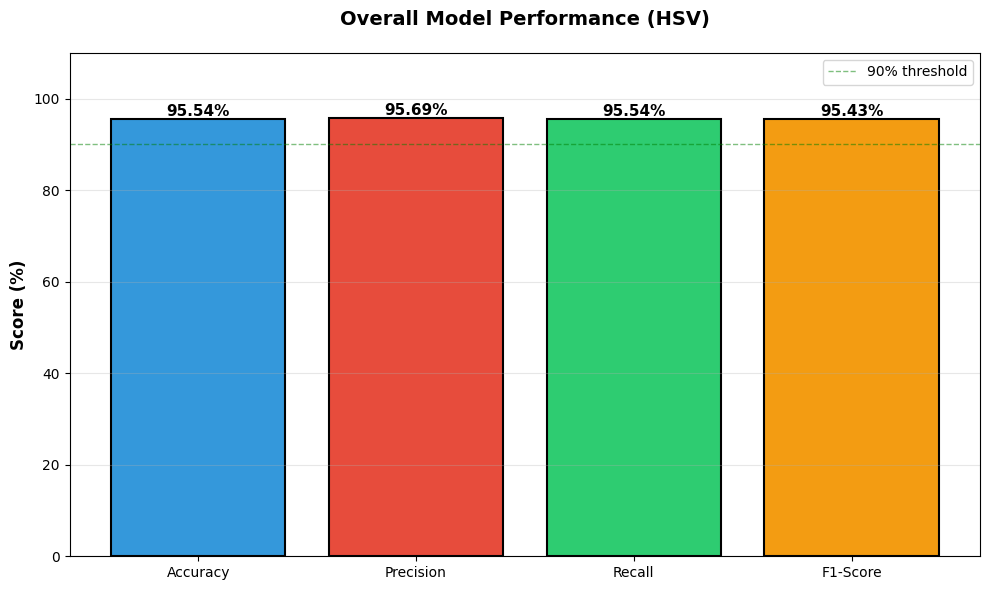

In [27]:
def plot_metrics_per_class(y_true, y_pred, class_names):
    """Vẽ biểu đồ metrics cho từng class"""
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    cm = confusion_matrix(y_true, y_pred)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    
    x = np.arange(len(class_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, accuracy_per_class, width, label='Accuracy', color='#9b59b6')
    bars2 = ax.bar(x - 0.5*width, precision_per_class, width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, recall_per_class, width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, f1_per_class, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics per Class (HSV Model)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("Metrics cho từng lớp (HSV)")
    print("=" * 70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': cm.sum(axis=1)
    })
    print(metrics_df.to_string(index=False))
    
    return metrics_df

metrics_df = plot_metrics_per_class(y_true, y_pred, class_names)

def plot_model_comparison():
    """So sánh các metrics tổng quan"""
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        test_results[1] * 100,
        test_precision * 100,
        test_recall * 100,
        test_f1 * 100
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, metrics_values, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance (HSV)', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1, alpha=0.5, label='90% threshold')
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()


In [28]:
print(f"""
=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: {image_size}x{image_size}x{channels} (HSV)
- Color Space: HSV (Hue-Saturation-Value)
- Số lớp phân loại: {num_classes}
- Tổng số parameters: {model.count_params():,}

=================Thông Tin Tập Dữ Liệu===================

- Training samples:   {train_generator.samples:>5} ({steps_per_epoch} steps/epoch)
- Validation samples: {validation_generator.samples:>5} ({validation_steps} steps)
- Test samples:       {test_generator.samples:>5} ({test_steps} steps)
- Classes: {', '.join(class_names)}

=================Thông Tin Hyperparameters===================

- Learning rate (initial): {learning_rate}
- Batch size: {batch_size}
- Epochs trained: {len(history.history['loss'])} / {epochs}
- Optimizer: Adam
- Loss function: Categorical Crossentropy

=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:    {history.history['accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['loss'][-1]:>6.4f}

Validation (Final):
  - Accuracy:    {history.history['val_accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['val_precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['val_recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['val_loss'][-1]:>6.4f}

Best Validation Metrics:
  - Best Accuracy:  {max(history.history['val_accuracy'])*100:.2f}% (epoch {np.argmax(history.history['val_accuracy'])+1})
  - Best Precision: {max(history.history['val_precision'])*100:.2f}%
  - Best Recall:    {max(history.history['val_recall'])*100:.2f}%

=================Kết Quả Trên Tập Test===================

- Test Accuracy:  {test_results[1]*100:>6.2f}%
- Test Precision: {test_precision*100:>6.2f}%
- Test Recall:    {test_recall*100:>6.2f}%
- Test F1-Score:  {test_f1*100:>6.2f}%
- Test AUC:       {test_results[4]:>6.4f}
- Test Loss:      {test_results[0]:>6.4f}

""")


=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: 150x150x3 (HSV)
- Color Space: HSV (Hue-Saturation-Value)
- Số lớp phân loại: 6
- Tổng số parameters: 3,601,478

=================Thông Tin Tập Dữ Liệu===================

- Training samples:    7245 (227 steps/epoch)
- Validation samples:  1355 (43 steps)
- Test samples:         448 (14 steps)
- Classes: 0, 1, 2, 3, 4, 5

=================Thông Tin Hyperparameters===================

- Learning rate (initial): 0.001
- Batch size: 32
- Epochs trained: 10 / 10
- Optimizer: Adam
- Loss function: Categorical Crossentropy

=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:     95.38%
  - Precision:    95.81%
  - Recall:       95.04%
  - Loss:        0.33